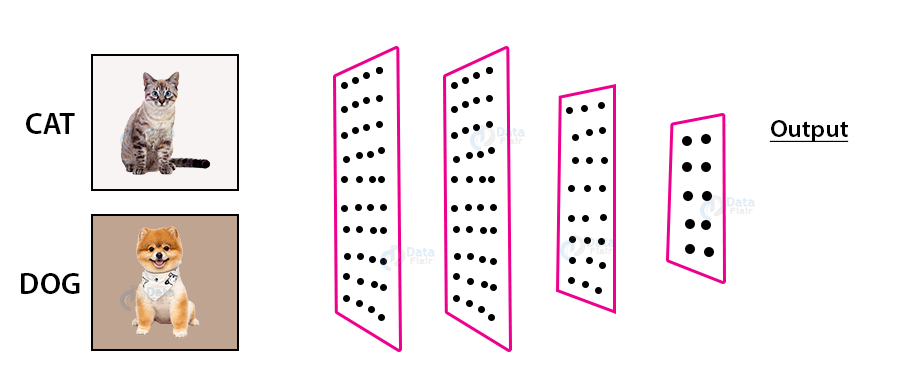

      
---
> **EfficientNet-B0 :** A convolutional neural network, with total number of *layers 237*, used to classify more than million images into 1000 object categories.

> EfficientNet-B0 is not pure PyTorch’s built-in model, so can only be called as given below. 

> Use command,  !pip install efficientnet_pytorch ,everytime you are going to use any EfficientNet


---




# Import Necessary Libraries

At first, we need to import some packages for implementation.

In [ ]:
#Importing Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, glob, time, copy, random, zipfile,random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score,precision_score
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

The latest PyTorch's version upon which we worked is ***1.12.1+cu113***

In [ ]:
#Importing PYTORCH Framework Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision.utils import make_grid
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

# Directing Pre-Processed Datasets 

Proper dataset preparation and loading complete data in required format is the most attention-demanding process in Machine Learning following the correct initialized variables, if any

> **Importing the Preprocessed Datasets**: 
   Make sure to mount drive, if you saved your preprocessed dataset on your drive before.

>  Format Verification and Listing
      As discussed before, dataset has been preprocessed into **.png** formatted images. Do insure to check and load for only **.png** images in order to bypass Google Colab generated checkpoints.
      Initialize variables containing list of images for better processing and computational speed.


In [ ]:
#Directing directives of stored preprocessed data
train_path = '/content/drive/MyDrive/data/train'
valid_path = '/content/drive/MyDrive/data/valid'
test_path = '/content/drive/MyDrive/data/test'

#Checking for only 'png' formatted 
train_list = glob.glob(os.path.join(train_path, '*.png'))
valid_list = glob.glob(os.path.join(valid_path, '*.png'))
test_list = glob.glob(os.path.join(test_path, '*.png'))

>  Let us visualize some random images from all datasets; namely ‘Train’, ‘Valid’ and ‘Test, in order to insure preprocessed image dataset and correct loading and listing.


>    Here loops are used for the purpose of displayed different images of cats and dogs,  each time you run the cell.

# Defining Classes

**Transformation and Augmentation**
> Mentioned earlier, dataset is released in Kaggle. Original dataset has 12500 images of dogs and 12500 images of cats, in 25000 images in total. That's a huge amount to train the model. But in our case, we just only use 600 images for training, 300 images for validation, and 300 images for test.

> Actually, 300 images are not enough datasets for training. But we can size-up the dataset with transformation. Yes, it is **Data Augmentation.** There are several techniques to transform the image. In this case, we will use following transformations:
*	Resize: Of course, model input must be the same size .So we need to resize our transformed image to fixed size. This fixed size gets declared by variable, defined later, based upon model selected.
*	Random Affine: We can use linear mapping method by preserving points, straight lines, and planes; comes from TorchVision.
*	Random Horizontal Flips: We can horizontally flip a targeted image with a given probability.

> One more API we need to implement is normalize. Normalization is one of method for rescaling. There are several techniques for normalization. But in this API, our normalize function will be based upon mean standard deviation values.

> **NOTE:**
*	If we use .Normalize( (0, 0, 0), (1, 1,1) ) instead of .Normalize (mean, std), we found to loss accuracy, both train and test, by 2 – 4%
*	Same transformation will be applied on Testing Data as now declared for Validation Data.



In [ ]:
#Defining Two Transformation (Testing will also use that of Validation)
class CustomTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
        transforms.Resize(size),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
            'valid':   transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

**Retrieval of Images and Labels**
> Usually dataset pipeline is built for training and test dataset. Actually, it is very efficiency for memory usage, because its type is python generator. We are done with it in Preprocessed step as following,

>	DATA
*	Train
*	Valid
*	Test

> Now we need to extract parent name as a target, to be later called by dataloader.

In [ ]:
class DogCatDataset(data.Dataset):
    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        image_loc = self.file_list[idx]
        image = Image.open(image_loc)
        
        img_transformed = self.transform(image, self.phase)
        
        # Get Target
        target = image_loc.split('/')[-1].split('.')[0]
        if     target == 'dog':      target = 0
        elif   target == 'cat':      target = 1
        else:  print('Wrong DATASET')

        return img_transformed, target


#Hyper Parameters

Tuned via performing various trainings and tests, checked that current model inputs **(224 x 224)** pixels image.

In [ ]:
#Defining Variables
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
size = 224
batch = 32   #Gives best result due to same Tensor .dtype

#Checking for GPU

>  Let’s check for availability of GPU.GPU helps to perform the training on large and complex datasets with ease as compared to CPU. So availability of GPU gives advantage on faster training of the model.

>   Since Google Colab provides a free ***12GB NVIDIA Tesla K80*** GPU to run up to 12 hours continuously, so using following command makes the code much flexible with respect to compute resources.

>   But here all the testing is performed on free version of Google Colab, so in order to prevent disturbance in runtime, hardware accelerator is set to **‘default’**, setting to GPU or TPU have significant impact on processing time

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

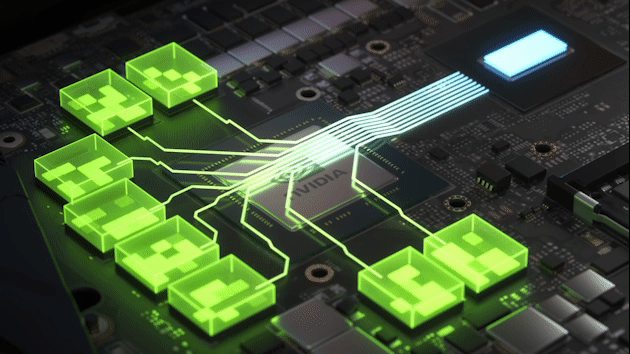

# Data Loader

Load the Training and Validation Dataset by calling previous made classes and print some check-marks for verification.

In [ ]:
#Making separate Datasets by call Custom Dataset Class
train_dataset = DogCatDataset(train_list, transform=CustomTransform(size, mean, std), phase='train')
valid_dataset = DogCatDataset(valid_list, transform=CustomTransform(size, mean, std), phase='valid')

# Verifivation
print('Verification')
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

Verification
torch.Size([3, 224, 224])
0


**Dictionary** has been initialized for the purpose of making code easy, and to prevent bugs. 

In [ ]:
#DataLoading (For Pytorch FrameWork)
train_dataloader = data.DataLoader(train_dataset, batch_size=batch, num_workers=4, shuffle=True)
valid_dataloader = data.DataLoader(valid_dataset, batch_size=batch, num_workers=4, shuffle=False)

#Dictionary for Simplifying and Compacting Code
loaderDict = {'train': train_dataloader, 'valid': valid_dataloader}

# Verification
print('Verification')
batch_iterator = iter(train_dataloader)
inputs, target = next(batch_iterator)
print(inputs.size())
print(target)

Verification


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 3, 224, 224])
tensor([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 0])


# Check Functionality of Data Augmentation

We have successfully applied data transformation, made the batches and loaded it to the data loader. Now, let's make a check point here, and visualize some random loaded train and validation data, in form of batches, for idea

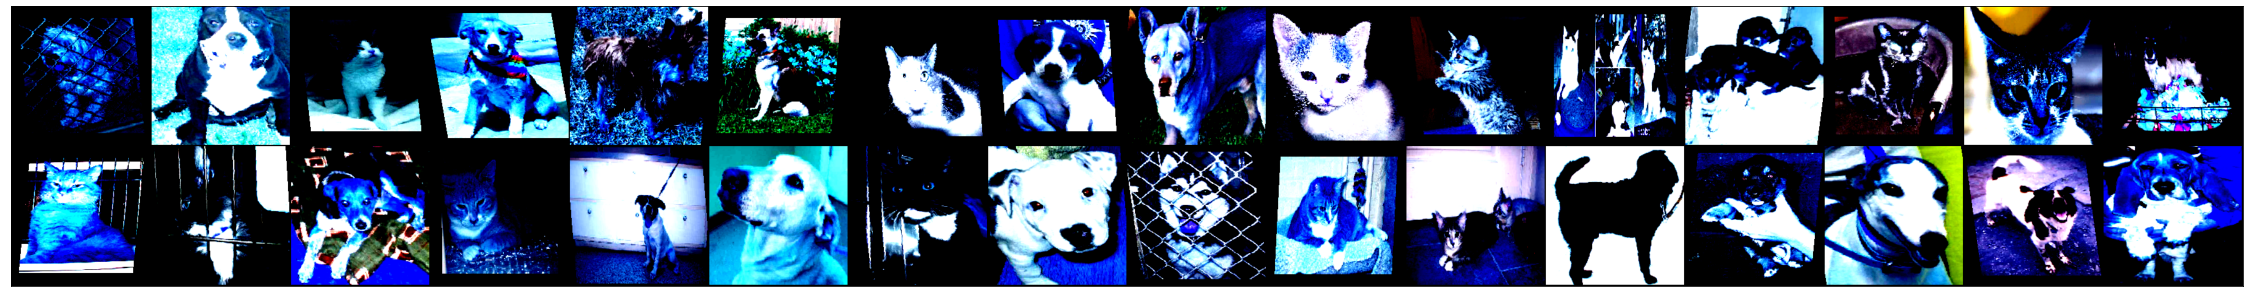

In [ ]:
#TRAINING DATALOADER
for images, labels in train_dataloader:
    
    fig, ax = plt.subplots(figsize = (40, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 16).permute(1,2,0))
    break

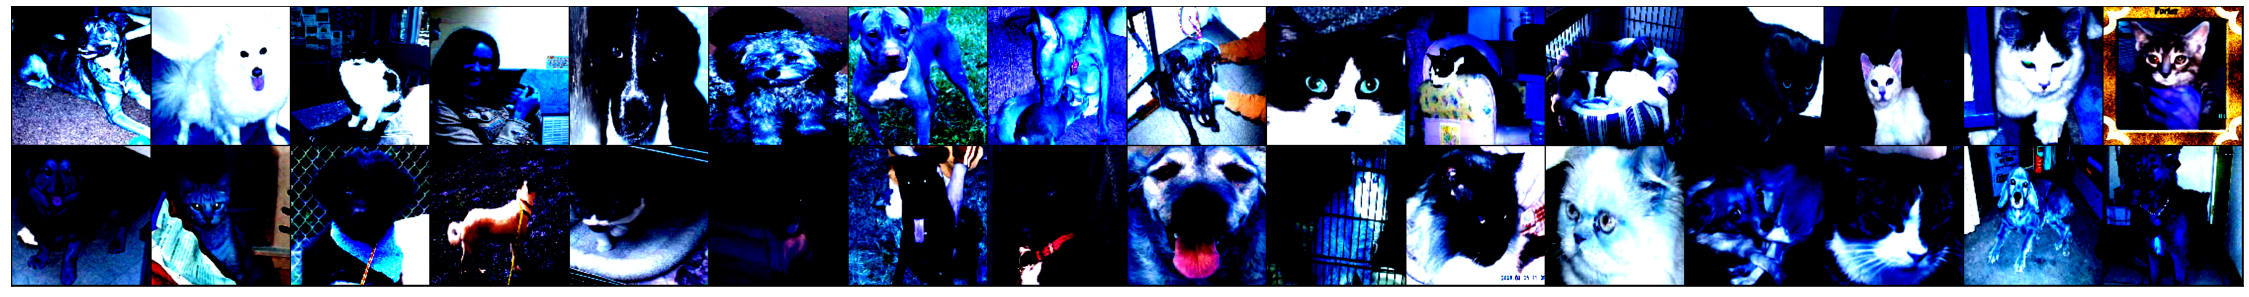

In [ ]:
#VALIDATION DATALOADER
for images, labels in valid_dataloader:
    
    fig, ax = plt.subplots(figsize = (40, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 16).permute(1,2,0))
    break

# Training

A function has been defined for model training, taking four arguments, 
*  Pre-trained model to be used
*  Criterion (mainly depending upon model selected)
*  Optimizer (mainly depending upon model selected) 
*  Number of epochs specified by user

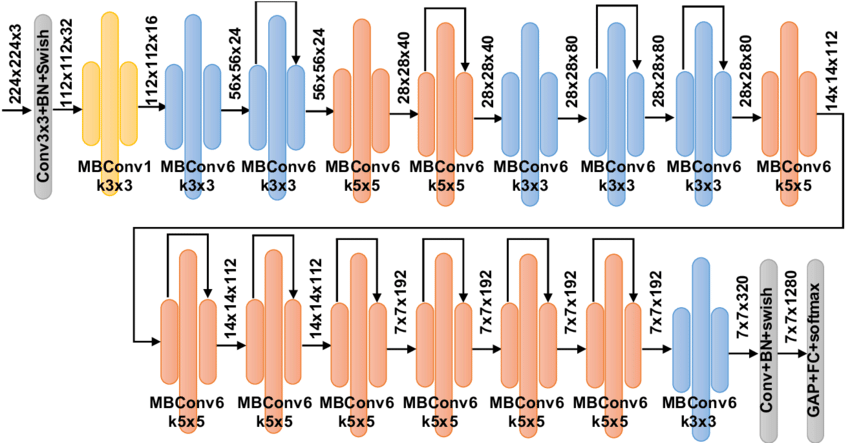

In [ ]:
def train_model(model, loaderDict, criterion, optimizer, num_epoch):
    
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    accuracy  = 0.0
    model = model.to(device)
    train_losses = []
    valid_losses = []

    for epoch in range(num_epoch):
        
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'valid']:
            
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, target in tqdm(loaderDict[phase]):
                inputs = inputs.to(device)
                target = target.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, target)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == target.data)
                    
            epoch_loss = epoch_loss / len(loaderDict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(loaderDict[phase].dataset)
            if phase == 'train':
              train_losses.append(epoch_loss)
            elif phase == 'valid':
              valid_losses.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'valid' and epoch_acc > accuracy :
                accuracy  = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('High Achieved validation Accuracy: {:4f}'.format(accuracy ))
    
    np.save('eff_trainloss.npy',train_losses)
    np.save('eff_validloss.npy',valid_losses)


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
def create_params_to_update(net):
    params_to_update_1 = []
    update_params_name_1 = ['_fc.weight', '_fc.bias']

    for name, param in net.named_parameters():
        if name in update_params_name_1:
            param.requires_grad = True
            params_to_update_1.append(param)
            #print("{} 1".format(name))
        else:
            param.requires_grad = False
            #print(name)

    params_to_update = [
        {'params': params_to_update_1}
    ]
    
    return params_to_update

In [ ]:
 #Defining PreTrained EfficientNet-B0 model 
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
net = EfficientNet.from_pretrained('efficientnet-b0')

net._fc = nn.Linear(in_features=1280, out_features=2)
params_to_update = create_params_to_update(net)

optimizer = optim.Adam(params=params_to_update, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=76d7e72dcdb98e18db16d444c5d18bca77b82de70b5ab1f43d285d08fdbbf71d
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
num_epoch = 15
net_trained = train_model(net, loaderDict, criterion, optimizer, num_epoch)

Epoch 1/15
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.5270 Acc: 0.8000


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.2883 Acc: 0.9467
Epoch 2/15
--------------------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.3334 Acc: 0.9017


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.1990 Acc: 0.9467
Epoch 3/15
--------------------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.2807 Acc: 0.9150


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.1671 Acc: 0.9500
Epoch 4/15
--------------------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.2323 Acc: 0.9133


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.1416 Acc: 0.9533
Epoch 5/15
--------------------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.2238 Acc: 0.9317


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.1347 Acc: 0.9600
Epoch 6/15
--------------------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.2016 Acc: 0.9350


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.1312 Acc: 0.9567
Epoch 7/15
--------------------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.2077 Acc: 0.9367


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.1252 Acc: 0.9633
Epoch 8/15
--------------------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.1879 Acc: 0.9383


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.1279 Acc: 0.9633
Epoch 9/15
--------------------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.1777 Acc: 0.9367


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.1296 Acc: 0.9667
Epoch 10/15
--------------------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.1668 Acc: 0.9433


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.1295 Acc: 0.9667
Epoch 11/15
--------------------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.1513 Acc: 0.9567


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.1306 Acc: 0.9633
Epoch 12/15
--------------------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.1639 Acc: 0.9417


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.1330 Acc: 0.9667
Epoch 13/15
--------------------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.1566 Acc: 0.9500


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.1358 Acc: 0.9600
Epoch 14/15
--------------------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.1764 Acc: 0.9400


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.1389 Acc: 0.9500
Epoch 15/15
--------------------


  0%|          | 0/19 [00:00<?, ?it/s]

train Loss: 0.1415 Acc: 0.9567


  0%|          | 0/10 [00:00<?, ?it/s]

valid Loss: 0.1407 Acc: 0.9500
Training complete in 22m 37s
High Achieved validation Accuracy: 0.966667


Arrays containing ***Training and Validation Losses*** have been stored to working directory and can be displayed as running following cell.

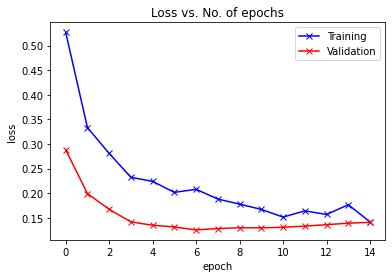

In [ ]:
train_loss = np.load('eff_trainloss.npy')
valid_loss= np.load('eff_validloss.npy')
plt.plot(train_loss, '-bx')
plt.plot(valid_loss, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');

# Saving the Model

Trained model will be saved on Mounted drive, for purpose of further usage. *(Testing or if, API)*

In [ ]:
torch.save(net_trained, '/content/drive/MyDrive/data/efficientnetb0.pt')
!pip install efficientnet_pytorch
model_saved = torch.load('/content/drive/MyDrive/data/efficientnetb0.pt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=bdda03bd9548ba659983a5c03f64b41e7e2e50dfa8f02a72f2c4b764e7f88a76
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


# Testing

Now, test the built model on Test Data, store the ID and predicted target as Pandas Dataframe, and save the final report as ***‘.csv’*** format

In [ ]:
# Prediction
id_list = []
propababilty_list = []

with torch.no_grad():
    for test_loc in tqdm(test_list):
        img = Image.open(test_loc)
        _id = int(test_loc.split('/')[-1].split('.')[0])

        transform = CustomTransform(size, mean, std)
        img = transform(img, phase='valid')
        img = img.unsqueeze(0)
        img = img.to(device)

        model_saved.eval()

        outputs = model_saved(img)
        propababilty = F.softmax(outputs, dim=1)[:, 1].tolist()

        id_list.append(_id)
        propababilty_list.append(propababilty[0])
    
    
dataFrame = pd.DataFrame({
    'id': id_list,
    'probability': propababilty_list
})

dataFrame.sort_values(by='id', inplace=True)
dataFrame.reset_index(drop=True, inplace=True)

dataFrame.to_csv('evaluation_report.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/300 [00:00<?, ?it/s]

Predicted dataframe has been previously saved on working directory as ***evaluation_report.csv***, now in order to access and read dataframe, run the following cell.

In [ ]:
display(dataFrame)

id  probability
0      0     0.805927
1      1     0.003141
2      2     0.120539
3      3     0.993177
4      4     0.270621
..   ...          ...
295  295     0.990743
296  296     0.049835
297  297     0.031980
298  298     0.028590
299  299     0.015136

[300 rows x 2 columns]

**Scatter Plot :** Visualize dataframe in form of *Scatter plot*.

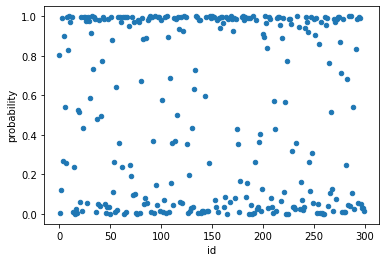

In [ ]:
dataFrame.plot(
    x = 'id',
    y='probability',
    kind='scatter'
)
plt.show()

**Binary Classification:**	
         Set the threshold, and make array of predicted target either as 0 or 1.

In [ ]:
temp = (dataFrame["probability"]) 
y_pred = np.zeros(300, dtype=int)
for i in range(len(temp)):
  if temp[i] > 0.59:
   y_pred[i] = 1
#Verification
print(y_pred)

[1 0 0 1 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0
 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1
 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0
 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0
 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0
 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0
 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 1
 0 0 0 0]


Upload the given Test Labels array and **assert** if length of actual labels array is not equal to predicted labels array. 

In [ ]:
y_actual = np.load('/content/labels_test.npy')
print(y_actual)
assert ((len(y_actual)) != (len(y_pred)), f"MISMATCHED LENGTHS" )

[1 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0
 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1
 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0
 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1
 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0
 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 0
 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1 1
 0 0 0 0]


<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-17-77a8b4e9ce17>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert ((len(y_actual)) != (len(y_pred)), f"MISMATCHED LENGTHS" )


# Results

It’s time to  visual the wrong predicted images by model by comparison between arrays.

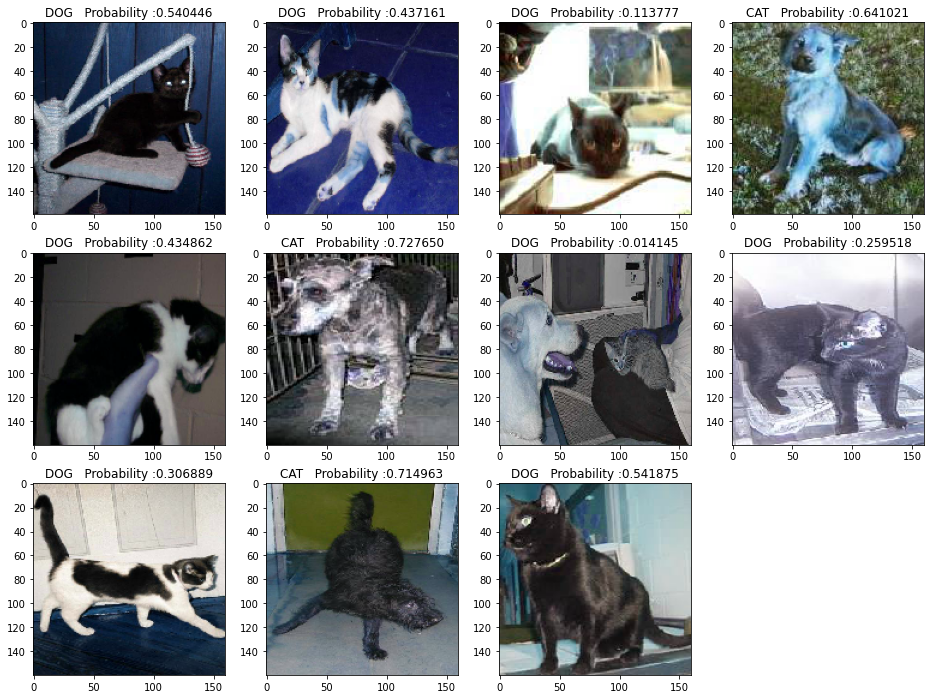

11


In [ ]:
mismatch = 0
id_list = []
fig = plt.figure(figsize=(16,12))
j=1
class_ = {1: 'CAT ', 0: 'DOG '}
for i in range(len(y_actual)):
  if y_actual[i] != y_pred[i]:
    img_path = os.path.join(test_path, '{}.png'.format(i))
    img = Image.open(img_path)
    #print(y_pred[i])
    #print(temp[i])
    plt.subplot(3, 4, j)
    plt.title(str(class_[y_pred[i]]) + "  Probability :{:4f}".format(temp[i]))
    plt.imshow(img) 
    mismatch+=1
    j+=1
plt.show()
print(mismatch)

Now, let's check model accuracy by terms including **F1 Score, Precision and Recall Scores.**


Total Mismatched : 11
F1_SCORE : 0.962712
Precision_Score : 0.979310
Recall_Score : 0.946667


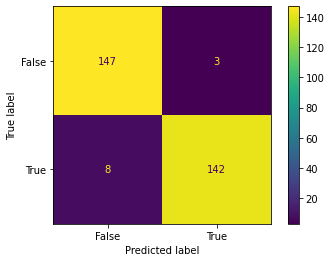

In [ ]:
print('Total Mismatched : {}'.format(mismatch))
print('F1_SCORE : {:4f}'.format(f1_score(y_actual, y_pred, average="binary")))
print('Precision_Score : {:4f}'.format(precision_score(y_actual, y_pred, average="binary")))
print('Recall_Score : {:4f}'.format(recall_score(y_actual, y_pred, average="binary")))

from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_actual, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

> **F1 Score :** Combines the precision and recall of a classifier into a single metric by taking their *Harmonic Mean,* and is is primarily used to compare the performance of two classifiers

> **Precision Score :** The ratio *tp / (tp + fp)* where tp is the number of true positives and fp the number of false positives.

> **Recall Score:** Represents the model's ability to correctly predict the positives out of actual positives

> **Confusion Matrix :** A useful machine learning method which allows you to measure Recall, Precision, and Accuracy. Below given can be used to know the terms:  True Positive, True Negative, False Negative, and True Negative. True Positive.

# Inference Time

>   In deep learning, inference time is the amount of time it takes for a machine learning model to process new data and make a prediction.
      
> To calculate estimated Inference Time, random 6 images have been taken from Google Search, uploaded on Drive and following code is run.

In [ ]:
#Estimating Inference Time
import torch
import time 
#!pip install efficientnet_pytorch
from torchvision import transforms
import torch.nn.functional as F
import glob
from PIL import Image

model = torch.load("/content/drive/MyDrive/data/efficientnetb0.pt")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

total = 0.0

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transf= transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

for x in glob.glob('/content/drive/MyDrive/Images/*.jpg'):
  image = Image.open(x)
  since = time.time()
  img = transf(image)
  img = img.unsqueeze(0)
  img = img.to(device)
  pred=model(img)
  pred = F.softmax(pred, dim=1)[:, 1]
  temp = pred[0] > 0.55
  if temp==1:
      print("PREDICTION = CAT ")
      print(' Probability : {:4f}'.format(pred.item()))
  else:
      print("PREDICTION = DOG ")
      print(' Probability : {:4f}'.format(1 - pred.item()))
  time_elapsed = time.time() - since
  total = total + time_elapsed

print('\n CALCULATED INFERENCE TIME : {}'.format(total/(float(6))) )


PREDICTION = CAT 
 Probability : 0.954215
PREDICTION = DOG 
 Probability : 0.630310
PREDICTION = DOG 
 Probability : 0.970803
PREDICTION = CAT 
 Probability : 0.966522
PREDICTION = CAT 
 Probability : 0.940486
PREDICTION = DOG 
 Probability : 0.461665

 CALCULATED INFERENCE TIME : 0.09827617804209392
